In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Jul_weekend.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 536.222296
  (4,4) => 0.0
  (3,1) => 517.943998
  (4,5) => 255.794432
  (2,4) => 248.012969
  (6,5) => 315.490644
  (8,4) => 263.62971
  (1,2) => 313.797844
  (5,1) => 303.650332
  (3,4) => 300.517441
  (8,2) => 192.202689
  (2,3) => 402.394129
  (2,6) => 455.190643
  (5,4) => 289.207933
  (2,1) => 444.307148
  (2,5) => 382.057561
  (8,5) => 314.506857
  (1,4) => 236.873166
  (2,8) => 225.933197
  (5,8) => 271.922411
  (4,8) => 253.590448
  (7,8) => 255.115956
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 355.385111
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Jul_dict = readall("../temp_files/link_day_minute_Jul_dict_JSON_adjusted.json");
link_day_minute_Jul_dict = replace(link_day_minute_Jul_dict, "NaN", 0);

link_day_minute_Jul_dict = JSON.parse(link_day_minute_Jul_dict);

In [12]:
# weekend_Jul_list = [1, 7, 8, 14, 15, 21, 22, 28, 29]

# training set 1
weekend_Jul_list_1 = [1, 7, 8, 14, 15, 21]

# training set 2
weekend_Jul_list_2 = [14, 15, 21, 22, 28, 29]

# training set 3
weekend_Jul_list_3 = [1, 7, 8, 22, 28, 29]

arcs_1 = Dict{(Int, Int), Arc}[]
for j in weekend_Jul_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["MD_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in weekend_Jul_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["MD_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in weekend_Jul_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["MD_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [14]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [536.222296,536.222296,536.222296,536.222296,536.222296,536.222296]
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [517.943998,517.943998,517.943998,517.943998,517.943998,517.943998]
  (4,5) => [255.794432,255.794432,255.794432,255.794432,255.794432,255.794432]
  (2,4) => [248.012969,248.012969,248.012969,248.012969,248.012969,248.012969]
  (6,5) => [315.490644,315.490644,315.490644,315.490644,315.490644,315.490644]
  (8,4) => [263.62971,263.62971,263.62971,263.62971,263.62971,263.62971]
  (1,2) => [313.797844,313.797844,313.797844,313.797844,313.797844,313.797844]
  (5,1) => [303.650332,303.650332,303.650332,303.650332,303.650332,303.650332]
  (3,4) => [300.517441,300.517441,300.517441,300.517441,300.517441,300.517441]
  (8,2) => [192.202689,192.202689,192.202689,192.202689,192.202689,192.202689]
  (2,3) => [402.394129,402.394129,402.394129,402.394129,402.394129,402.394129]
  (2,6) => [455.190643,455.190643,455.190643,4

In [15]:
flow_data_3

24x6 Array{Float64,2}:
 2641.73  2617.04  2196.59   2620.79  2189.58  2515.6 
 2533.83  2001.5   1882.59   2142.58  2010.89  2502.08
 1479.04  1656.48  1490.3    1528.18  1390.02  1572.53
 1852.31  1501.68  1243.18   1102.28  1531.6   1590.07
 1457.9   1499.26  1750.54   1997.63  1865.88  1972.45
 2366.24  2481.2   2150.11   2528.74  2306.36  2773.9 
 2755.06  1912.47  2397.79   2224.81  1969.07  2632.44
 2307.05  1696.29  2139.8    2232.1   1540.42  2482.62
 1611.68  1390.98  1563.67   1314.95  1181.94  1472.34
 2056.41  1695.31  1912.7    1875.97  1479.3   2196.48
 2213.14  1841.42  2433.53   2270.92  1882.88  2736.97
 2243.47  1656.48  2020.9    2088.1   1786.9   2439.14
 1709.48  1554.16  1869.97   2303.75  1299.3   2463.7 
 1537.34  1150.3    991.692  1314.95  1276.6   1782.84
 1855.33  1419.95  2107.86   2130.97  1303.01  2205.01
 2379.18  1776.94  2096.01   2146.9   1720.19  2209.97
 1457.82  1411.16   693.528  1433.65  1095.6   1624.54
 1834.05  1531.46  1834.94   1501.53  1454

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")

coeffs_dict_Jul_weekend = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Jul_weekend[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Jul_weekend[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Jul_weekend[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [18]:
outfile = open("../temp_files/coeffs_dict_Jul_weekend.json", "w")

JSON.print(outfile, coeffs_dict_Jul_weekend)

close(outfile)

In [19]:
coeffs_dict_Jul_weekend_ = readall("../temp_files/coeffs_dict_Jul_weekend.json")
coeffs_dict_Jul_weekend_ = JSON.parse(coeffs_dict_Jul_weekend_)

Dict{UTF8String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.0049596542274962805,0.0020258165012220445,0.0004…
  "(5,0.5,100.0,3)"   => {1.0,0.003370051500479378,0.0064488060866942625,0.00048…
  "(6,1.5,10.0,3)"    => {1.0,0.004829909911486356,0.0023639514014336662,0.00060…
  "(6,2.0,0.1,2)"     => {1.0,0.003616524262802257,-0.004244408217973139,0.00060…
  "(4,0.5,1000.0,1)"  => {1.0,0.004736262296564696,0.005534047902349774,0.002023…
  "(6,2.0,0.01,1)"    => {1.0,0.004757794596739137,-0.06001595822146275,0.161019…
  "(8,1.5,0.01,1)"    => {1.0,0.016844712339347735,-0.12999545957707118,0.186067…
  "(5,1.5,1.0,1)"     => {1.0,0.0038663478905388597,0.007790122182555213,0.00270…
  "(8,2.5,0.001,2)"   => {1.0,0.021027143418131646,-0.2075240496563931,0.4868076…
  "(4,2.0,0.1,1)"     => {1.0,-0.004990697140459321,0.03140566490460057,0.006899…
  "(5,1.0,1000.0,2)"  => {1.0,0.002252471816444092,0.0012269937464180743,0.00023…
  "(4,2.0,0.1,2)"     => {1.0,0.0032132964160564194,-0.0024

In [20]:
coeffs_dict_Jul_weekend_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
  1.0       
 -0.00247036
  0.0552872 
 -0.205751  
  0.586355  
 -0.922929  
  0.894239  
 -0.468892  
  0.104135  

INFO: Loading help data...


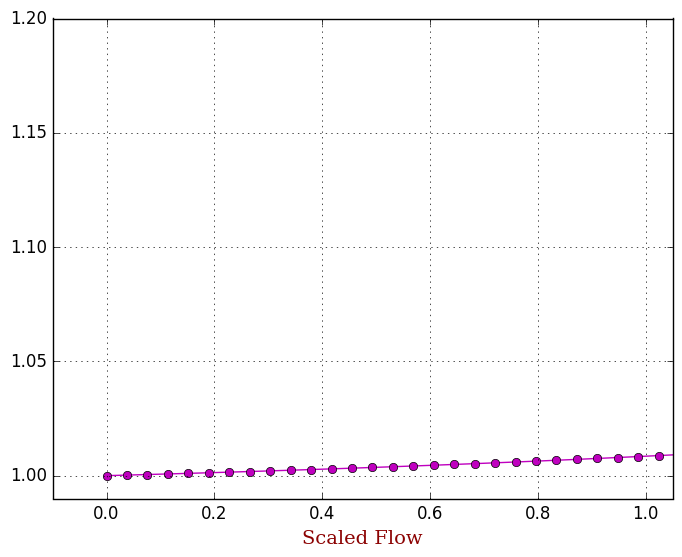

In [21]:
using PyPlot

fcoeffs = coeffs_dict_Jul_weekend_["(5,2.5,10000.0,1)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Jul_weekend")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Jul_weekend.pdf")